In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


In [2]:
DATA_PATH = os.path.join("..", "..", "..", "data")  # document-wide constants are uppercase by convention

# 2
# a: Plot, correlogram, and ADF test

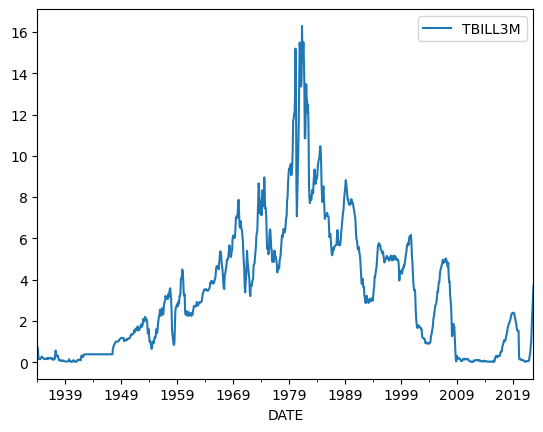

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "tbill.csv"), index_col="DATE")
df.index = pd.DatetimeIndex(df.index, dayfirst=True).to_period('M')
df.plot();

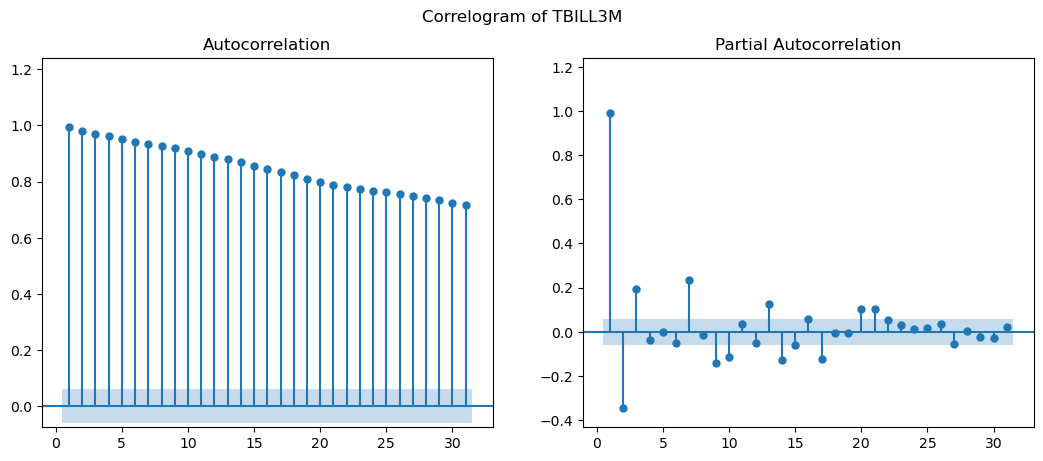

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of TBILL3M')
sm.graphics.tsa.plot_acf(df, ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(df, ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");

From the correlogram, it looks like the T-Bill rate is I(1): the autocorrelations are large and decay slowly and approximately linearly. We can confirm this with an ADF test. The data don't seem to have a trend. One could argue that there is a breaking trend, [upwards until around 1982, downwards thereafter](https://www.statista.com/statistics/1338105/volcker-shock-interest-rates-unemployment-inflation), but this kind of test is not available in `statsmodels`. Thus, we include just an intercept by passing `regression='c'`,  because the mean is not zero. Other options include `regression='ct'` (constant and trend) and `regression='n'` (neither constant nor trend). We choose automatic lag length selection based on the AIC (which is also the default).

In [5]:
ADF, p, crits, res = tsa.stattools.adfuller(df, regression='c', autolag='AIC', store=True)
print("ADF = ", ADF, "\np   = ", p)

ADF =  -2.206151587015458 
p   =  0.20402036648376515


The output provides the observed test statistic, the $p$-value, the critical values, and the details of the test regression (if `store=False` is passed, the output differs; we do this so we can look at the test regression below).

The observed test statistic is -2.206, larger than the critical value -2.86, so the test does not reject the null that the data are I(1), as expected. The same conclusion can be drawn from the $p$-value of 0.2043.

The simple call to `adfuller` above hides a lot of the complexity, so let us re-run the test manually. As discussed in the slides, the test regression is
$$ \Delta y_{t}= \psi y_{t-1}+\alpha _{1} \Delta y_{t-1}+\ldots +\alpha _{p^*} \Delta y_{t-{p^*}}+ u _{t},$$ that is, we regress the first difference $\Delta y_{t}$ on the lagged level and $p^\ast$ lags of $\Delta y_{t}$; in the example, $p^\ast$ was chosen as 21 based on the AIC. We can look at the test regression as follows.

In [6]:
print(res.resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     18.99
Date:                Wed, 04 Oct 2023   Prob (F-statistic):           1.43e-61
Time:                        15:29:09   Log-Likelihood:                -243.81
No. Observations:                1044   AIC:                             533.6
Df Residuals:                    1021   BIC:                             647.5
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0071      0.003     -2.206      0.0

Here, the dependent varialble `y` refers to $\Delta y_t$, the regressor `x1` refers to $y_{t-1}$, and then `x2` refers to $\Delta y_{t-1}$, `x3` refers to $\Delta y_{t-2}$, etc. The test statistic is the $t$-statistic on the lagged level, so -2.206. It is important though that the $p$-value given in the regression output, 0.028, is incorrect; this is because it is computed based on the normal distribution, whereas we need the $p$-value (or alternatively the critical value) from the Dickey-Fuller distribution. Using the correct critical value of -2.86, the test does not reject, so the data are I(1). **Note**: In previous exams, I have sometimes given the regression output above, rather than the test results explicitly. In that case, you'd need to figure out (i) where to find the test statistic (-2.206), (ii) not to use the provided $p$-value (0.028), and (iii) which critical value to use (-2.86, because only an intercept was included). A table of the Dickey Fuller distribution will be included with the exam. 

# 2
## b: ARIMA modeling
We start by inspecting the correlogram of the first difference.

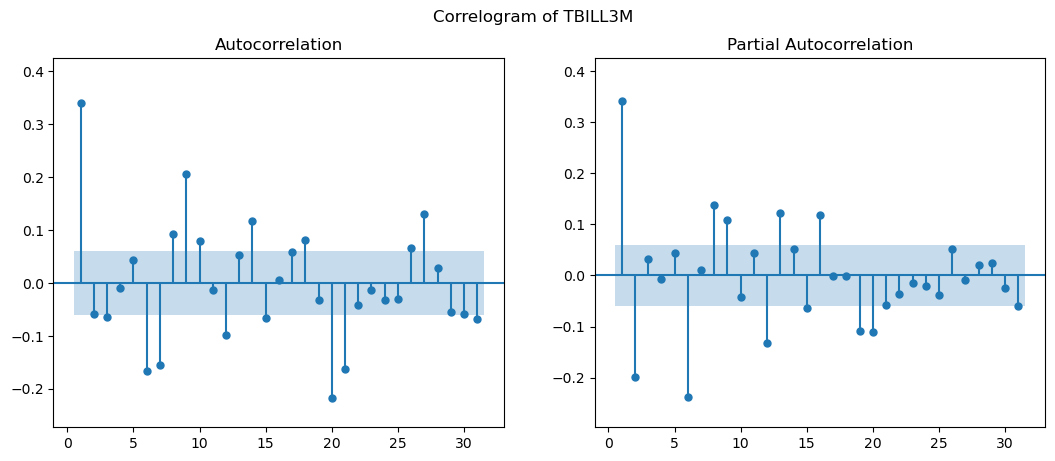

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of TBILL3M')
sm.graphics.tsa.plot_acf(df["TBILL3M"].diff().dropna(), ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(df["TBILL3M"].diff().dropna(), ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");

It looks stationary (as it should; it's the first difference of an I(1) process), but there is clearly some autocorrelation visible. The next step is to try and remove this autocorrelation by modeling the first difference as an ARMA process. This turns out to be quite difficult; the autocorrelation structure doesn´t give us a lot of cues, so it is natural to start with an ARMA(1, 1).

                               SARIMAX Results                                
Dep. Variable:                TBILL3M   No. Observations:                 1065
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -332.992
Date:                Wed, 04 Oct 2023   AIC                            673.984
Time:                        15:29:10   BIC                            693.867
Sample:                    02-28-1934   HQIC                           681.518
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.015      0.200      0.842      -0.026       0.032
ar.L1         -0.1611      0.024     -6.641      0.000      -0.209      -0.114
ma.L1          0.5808      0.023     25.051      0.0

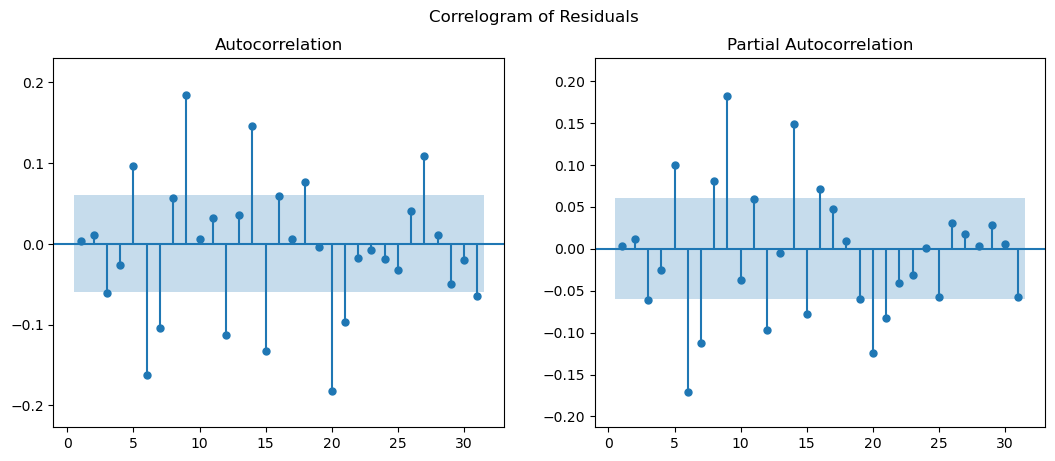

In [8]:
mod = ARIMA(df["TBILL3M"].diff().dropna(), order=(1, 0, 1)).fit()
print(mod.summary())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Residuals')
sm.graphics.tsa.plot_acf(mod.resid, ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(mod.resid, ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");

Clearly, there is some autocorrelation left. Since its unclear in which direction to extend the model, I just estimate a bunch of them and pick the one with the lowest BIC. Fortunately, this can be automated in `statsmodels`; the following estimates all combinations of $p$ and $q$ up to $p=q=6$, and choses the best model based on the BIC.

In [9]:
tsa.stattools.arma_order_select_ic(df["TBILL3M"].diff().dropna(), max_ar=6, max_ma=6, ic='bic', trend='c')

/home/broda/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/broda/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/broda/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/broda/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/broda/anaconda3/lib/python3

{'bic':             0           1           2           3           4           5  \
 0  856.895634  690.115630  694.217531  701.174213  689.840736  679.866763   
 1  732.504491  693.867134  699.556043  698.388987  685.776928  686.522385   
 2  697.112737  695.534772  706.456454  672.076490  679.274291  665.395094   
 3  702.986844  693.589608  699.758455  672.264986  670.790438  657.573982   
 4  709.916312  698.631804  706.587031  663.150913  669.195417  654.723425   
 5  714.811133  697.162658  702.201579  667.627654  673.375601  646.295415   
 6  660.726273  667.639888  651.810702  651.559756  652.144441  653.265285   
 
             6  
 0  685.648139  
 1  685.085095  
 2  653.315031  
 3  659.608659  
 4  663.975870  
 5  662.974204  
 6  653.970788  ,
 'bic_min_order': (5, 5)}

So according to the BIC, an ARMA(5, 5) is the best model. Estimating it yields

/home/broda/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                TBILL3M   No. Observations:                 1065
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -281.323
Date:                Wed, 04 Oct 2023   AIC                            586.647
Time:                        15:29:55   BIC                            646.295
Sample:                    02-28-1934   HQIC                           609.248
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.014      0.208      0.835      -0.024       0.030
ar.L1          0.9233      0.049     18.658      0.000       0.826       1.020
ar.L2         -1.0625      0.076    -13.932      0.0

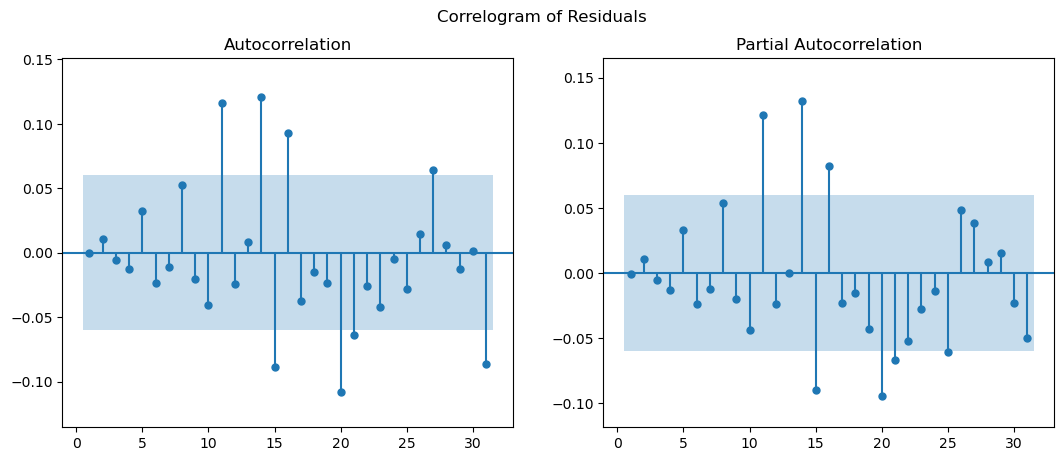

In [10]:
mod = ARIMA(df["TBILL3M"].diff().dropna(), order=(5, 0, 5)).fit()
print(mod.summary())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Residuals')
sm.graphics.tsa.plot_acf(mod.resid, ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(mod.resid, ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");

Some autocorrelation remains, but we won't bother to model it. Thus, our final model is an ARMA(5, 5) for $\Delta$ TBILL3M. This corresponds to an ARIMA(5, 1, 5) for the levels, TBILL3M.

# 2
## c: Forecasting
To forecast an ARIMA model, we first forecast the ARMA model for the first difference. We'll spare us the hassle of doing a manual forecast for this complicated model, and just let Python do the heavy lifting:

In [11]:
df.tail()

,TBILL3M
DATE,
2022-06,1.49
2022-07,2.23
2022-08,2.63
2022-09,3.13
2022-10,3.72


In [12]:
mod.predict("2022-11")

2022-11    0.163609
Freq: M, dtype: float64

In [13]:
mod.predict("2022-12")

2022-12   -0.032979
Freq: M, dtype: float64

The forecasts are $\widehat{\Delta\mbox{TBILL}}_{2022M11}=0.1636$ and $\widehat{\Delta\mbox{TBILL}}_{2022M12}=-0.0330$. The T-Bill rate in 2022M10 was 3.72, so the corresponding forecasts for the levels are
\begin{align*}
\widehat{\mbox{TBILL}}_{2022M11}&=3.72+0.1636=3.8836,\qquad\mbox{and}\\
\widehat{\mbox{TBILL}}_{2022M12}&=3.8836-0.0330=3.8506.
\end{align*}